La Encuesta Permanente de Hogares (EPH) es un programa nacional de producción sistemática y permanente de indicadores sociales que lleva a cabo el Instituto Nacional de
Estadística y Censos (INDEC), que permite conocer las características sociodemográficas y
socioeconómicas de la población. Uno de los indicadores más valiosos que pueden obtenerse
con los datos extraídos de esta encuesta es la tasa de pobreza con el método de ingresos.
Para esto se confecciona una canasta de bienes y servicios esenciales que permite dividir entre quiénes pueden acceder a ella-no pobres- y quienes no pueden adquirirla, considerados pobres. 
Sin embargo para realizar la clasificación es necesario conocer el nivel de ingresos de los encuestados. Pero en muchos casos esta información no es brindada por el público, dificultando la clasificación. 
Es por ello que nos proponemos construir una serie de modelos que permitan clasificar la situación de pobreza para quienes no informaron sus ingresos. 

### Parte I: Analizando la base

In [1]:
#importamos los paquetes
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import statsmodels.api as sm

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Vamos a usar una base reducida. Sobre ella vamos a calcular todas las columnas con valores negativos.

In [2]:
df = pd.read_csv("indiv.csv")

columnas= df.columns
res=[]
for i in range(df.shape[1]):
    if df[columnas[i]].dtypes == int or df[columnas[i]].dtypes == float :
        res.append( (df[columnas[i]]<0).sum()) 
    else:
        res.append(None) 
    
row=pd.Series(res,df.columns)
df1= df.append([row],ignore_index=True)
columnas_con_neg=[]

for i in range(df1.shape[1]):
    if df1.loc[10352, df1.columns[i]]>0:
        columnas_con_neg.append(df.columns[i])
        print (df1.columns[i],df1.loc[10352,df1.columns[i]] )

CH06 104.0
PP06C 274.0
PP06D 125.0
PP08D1 710.0
PP08F1 47.0
PP08F2 14.0
PP08J1 183.0
PP08J2 9.0
P21 1106.0
TOT_P12 135.0
P47T 1527.0
V2_M 229.0
V3_M 10.0
V4_M 1.0
V5_M 20.0
V8_M 25.0
V9_M 2.0
V10_M 26.0
V11_M 7.0
V12_M 85.0
V18_M 1.0
V21_M 83.0
T_VI 395.0


Vamos a borrar columnas con valores negativos pero primero vamos a excluir las variables P47T (Monto total de ingreso individual percibido en ese mes) y P21 (Monto de ingreso de la ocupación principal percibido en ese mes) para no generar sesgo  con los desocupados e inactivos

In [3]:
columnas_con_neg.remove("P47T")
columnas_con_neg.remove("P21")

Ahora sí, borramos columnas con valores negativos

In [4]:
for d in range(len(columnas_con_neg)):   
    df= df[~(df[columnas_con_neg[d]] < 0)]

Mostramos la composicion de los encuestados por sexo

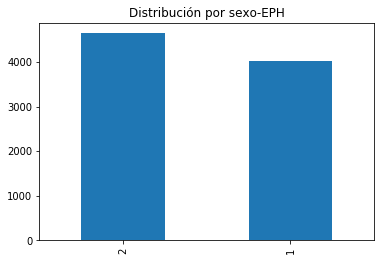

In [5]:
df['CH04'].value_counts().plot(kind='bar')

plt.title("Distribución por sexo-EPH")
plt.bars=("MUJERES", "HOMBRES")

Observamos que la composición de mujeres(x=2) es mayor a la de hombres (x=1)

Ahora realizamos una matriz de correlación con las variables: 
Sexo, Situación Conyugal, Cobertura Médica, Nivel Educativo, Condición de Actividad, Categoría de inactivo e Ingreso Familiar. 

[Text(0.5, 0, 'CH04'),
 Text(1.5, 0, 'CH07'),
 Text(2.5, 0, 'CH08'),
 Text(3.5, 0, 'NIVEL_ED'),
 Text(4.5, 0, 'ESTADO'),
 Text(5.5, 0, 'CAT_INAC'),
 Text(6.5, 0, 'IPCF')]

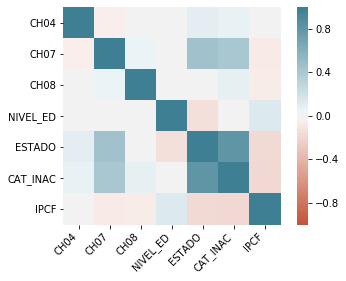

In [6]:
df1 = df[["CH04", "CH07","CH08", "NIVEL_ED", "ESTADO", "CAT_INAC", "IPCF"]]
corr = df1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

Se ve que hay una correlación negativa entre Nivel de educación y Condición laboral (Estado), lo cual indica la menor inserción en el mercado de trabajo para quienes no poseen muchas calificaciones educativas.

También se ve que hay una relación positiva entre Situación conyugal (CH07) y Estado, evidenciando que la tasa de ocupación cae en aquellas personas que tienen una relación conyugal.

Logicamente la relación entre Ingresos(IPCF) y Condición Laboral es negativa, expresando que quienes estan inactivos o desocupados obtienen menos ingresos que quienes estan ocupados. 

In [7]:
OCUPADOS = df[df.ESTADO==1]
DESOCUPADOS = df[df.ESTADO==2]
INACTIVOS = df[df.ESTADO==3]

In [8]:
# Calculamos cantidad de desocupados
DESOCUPADOS["ESTADO"].value_counts()

2    546
Name: ESTADO, dtype: int64

In [9]:
# Calculamos cantidad de inactivos
INACTIVOS["ESTADO"].value_counts()

3    3629
Name: ESTADO, dtype: int64

In [10]:
# Calculamos IPCF promedio de los OCUPADOS
OCUPADOS["IPCF"].mean()

15694.966184751664

In [11]:
#Calculamos IPCF pronedio de los DESOCUPADOS
DESOCUPADOS["IPCF"].mean()

7979.825622710623

In [12]:
# Calculamos el IPCF promedio de los INACTIVOS
INACTIVOS["IPCF"].mean()

9360.440810140535

In [13]:
# Personas que NO respondieron Ingresos Totales familiares
df[df.ITF==0]["ITF"].count()

2099

Vamos a utilizar el archivo del INDEC 'tabla_adulto_equiv.xlsx' con el proposito
de generar una columna que indique el equivalente de adulto de cada encuestado.

In [14]:
df2 = pd.read_excel('tabla_adulto_equiv.xlsx')
def read_adulto_equiv():
    df2 = pd.read_excel('tabla_adulto_equiv.xlsx', skiprows=3, nrows=24)
    df2 = df2.iloc[1:,0:3]
    return df2

df2 = read_adulto_equiv()
df2.iloc[0,0] = '0'

In [15]:
df2["Edad"]

1                  0
2               1año
3             2 años
4             3 años
5             4 años
6             5 años
7             6 años
8             7 años
9             8 años
10            9 años
11           10 años
12           11 años
13           12 años
14           13 años
15           14 años
16           15 años
17           16 años
18           17 años
19      18 a 29 años
20      30 a 45 años
21      46 a 60 años
22      61 a 75 años
23    más de 75 años
Name: Edad, dtype: object

In [16]:
df2["Edad"] = df2.Edad.apply(lambda x: re.sub("\D", " ", x).strip())
df2["Edad"]

1           0
2           1
3           2
4           3
5           4
6           5
7           6
8           7
9           8
10          9
11         10
12         11
13         12
14         13
15         14
16         15
17         16
18         17
19    18   29
20    30   45
21    46   60
22    61   75
23         75
Name: Edad, dtype: object

In [17]:
df2 = df2.set_index("Edad")

In [18]:
df2

,Mujeres,Varones
Edad,,
0,0.35,0.35
1,0.37,0.37
2,0.46,0.46
3,0.51,0.51
4,0.55,0.55
5,0.60,0.60
6,0.64,0.64
7,0.66,0.66
8,0.68,0.68


In [19]:
for index, row in df.iterrows():
    edad = row.CH06
    sexo = row.CH04

    if sexo == 1:
        df_temp = df2[["Mujeres"]]
    else:
        df_temp = df2[["Varones"]]

    if edad in range(0, 18):
        adulto_equiv = df_temp.loc[str(edad)] 
    elif edad in range(18, 29+1):
         adulto_equiv = df_temp.loc['18   29']
    elif edad in range(30, 45+1):
         adulto_equiv = df_temp.loc['30   45']
    elif edad in range(46, 60+1):
         adulto_equiv = df_temp.loc['46   60']
    elif edad in range(61, 75):
         adulto_equiv = df_temp.loc['61   75']
    elif edad >= 75:
         adulto_equiv = df_temp.loc['75']
    
    #print(edad, sexo, adulto_equiv)
    df.loc[index, 'adulto_equiv'] = adulto_equiv[0]
  

In [20]:
#creamos una columna con la proporción de adulto equivalente de cada encuestado 
df["ad_equiv_hogar"] = df.groupby(["CODUSU"])["adulto_equiv"].transform(np.sum)

Vamos a separar la base en 2, según si respondieron o no a la pregunta 
"Cuántas personas no respondieron cuál es su ingreso total familiar (ITF)?"

In [21]:
norespuesta = df[df.ITF == 0].copy()
respondieron = df[df.ITF > 0].copy()
norespuesta.reset_index(inplace= True)
respondieron.reset_index(inplace= True)
respondieron.to_csv("respondieron", index=False)
norespuesta.to_csv("norespuesta", index=False)

Creamos una columna que diga el ingreso necesario para no ser pobre según valores 
del 1er trimestre de 2019 cuando la canasta de un adulto equivalente valía $8928

In [22]:
respondieron["ingreso_necesario"] = respondieron["ad_equiv_hogar"] * 8928

respondieron["Pobre"] = np.where(respondieron.ingreso_necesario < respondieron.ITF, 0, 1)

x = respondieron["Pobre"].value_counts()[1]
print("Hay {} pobres".format(x))

Hay 2281 pobres


In [23]:
respondieron.head()

,index,Unnamed: 0,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,CH03,CH04,CH05,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,CH15,CH15_COD,CH16,CH16_COD,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,IMPUTA,PP02C1,PP02C2,PP02C3,PP02C4,PP02C5,PP02C6,PP02C7,PP02C8,PP02E,PP02H,PP02I,PP03C,PP03D,PP3E_TOT,PP3F_TOT,PP03G,PP03H,...,PP11T,P21,DECOCUR,IDECOCUR,RDECOCUR,GDECOCUR,PDECOCUR,ADECOCUR,PONDIIO,TOT_P12,P47T,DECINDR,IDECINDR,RDECINDR,GDECINDR,PDECINDR,ADECINDR,PONDII,V2_M,V3_M,V4_M,V5_M,V8_M,V9_M,V10_M,V11_M,V12_M,V18_M,V19_AM,V21_M,T_VI,ITF,DECIFR,IDECIFR,RDECIFR,GDECIFR,PDECIFR,ADECIFR,IPCF,DECCFR,IDECCFR,RDECCFR,GDECCFR,PDECCFR,ADECCFR,PONDIH,adulto_equiv,ad_equiv_hogar,ingreso_necesario,Pobre
0,1,2,TQRMNOQWRHLNMNCDEIJAH00605319,2019,1,1,1,1,1,S,33,1396,1,1,32213,31,5,4,1,2,0,4,1,NaN,1,NaN,1,NaN,4,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,77.0,0.0,2.0,0.0,...,NaN,15000.0,5,NaN,4,5,NaN,5,1790,0.0,15000.0,5,NaN,5,5,NaN,5,1837,0,0.0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,30000.0,5.0,NaN,5.0,5.0,NaN,5.0,15000.0,7.0,NaN,6.0,6.0,NaN,7.0,1858,0.77,1.53,13659.84,0
1,2,3,TQRMNOQWRHLNMNCDEIJAH00605319,2019,1,1,2,1,1,S,33,1396,8,1,33299,28,5,4,1,2,0,4,1,NaN,1,NaN,1,NaN,4,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,77.0,0.0,2.0,0.0,...,NaN,15000.0,5,NaN,4,5,NaN,5,2018,0.0,15000.0,5,NaN,5,5,NaN,5,1935,0,0.0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,30000.0,5.0,NaN,5.0,5.0,NaN,5.0,15000.0,7.0,NaN,6.0,6.0,NaN,7.0,1858,0.76,1.53,13659.84,0
2,3,4,TQRMNOSRUHLNMNCDEIJAH00610905,2019,1,1,1,1,1,S,33,1396,1,2,24365,52,1,1,1,2,0,2,1,NaN,3,90.0,1,NaN,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0,2.0,48.0,12.0,2.0,0.0,...,NaN,9000.0,3,NaN,3,3,NaN,3,1727,4500.0,13500.0,5,NaN,4,5,NaN,5,1698,0,0.0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,35500.0,6.0,NaN,6.0,6.0,NaN,6.0,8875.0,4.0,NaN,4.0,4.0,NaN,4.0,2681,1.00,3.54,31605.12,0
3,4,5,TQRMNOSRUHLNMNCDEIJAH00610905,2019,1,1,2,1,1,S,33,1396,2,1,25215,50,1,1,1,2,0,2,1,NaN,3,22.0,1,NaN,2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,49.0,0.0,2.0,0.0,...,NaN,12000.0,4,NaN,4,4,NaN,4,2022,0.0,12000.0,4,NaN,4,4,NaN,4,1876,0,0.0,0,0,0.0,0,0,0,0,0.0,0,0,0.0,35500.0,6.0,NaN,6.0,6.0,NaN,6.0,8875.0,4.0,NaN,4.0,4.0,NaN,4.0,2681,0.76,3.54,31605.12,0
4,5,6,TQRMNOSRUHLNMNCDEIJAH00610905,2019,1,1,3,1,1,S,33,1396,3,1,35146,23,1,4,1,1,1,4,2,2.0,1,NaN,1,NaN,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,12.0,0.0,1.0,1.0,...,NaN,5000.0,2,NaN,2,2,NaN,2,1805,0.0,10000.0,4,NaN,3,3,NaN,4,1876,0,0.0,0,0,0.0,0,0,5000,0,0.0,0,0,5000.0,35500.0,6.0,NaN,6.0,6.0,NaN,6.0,8875.0,4.0,NaN,4.0,4.0,NaN,4.0,2681,0.76,3.54,31605.12,0


### PARTE 2 - Clasificacion

Eliminamos de la spreadsheet "respondieron" y "norespondieron" todas las variables
asociadas a ingresos para evitar colinearidad. De la misma manera, quitamos las columnas relacionadas a adulto equivalente, adulto equivalente por hogar e ingreso necesario. También dejamos afuera a variables que no aportan información sensible como TRIMESTRE, CODUSU, etc.

In [24]:


respondieron = df[df.ITF > 0].copy()
respondieron["ingreso_necesario"] = respondieron["ad_equiv_hogar"] * 8928
respondieron["Pobre"] = np.where(respondieron.ingreso_necesario < respondieron.ITF, 0, 1)

eliminar = ["PP08D1", "PP08D4", "PP08F1",
            "PP08F2", "PP08J1", "PP08J2", 
            "PP08J3", "P21", "TOT_P12", "P47T",
            "V2_M", "V3_M", "V3_M", "V4_M", "V5_M",
            "V8_M", "V9_M", "V10_M", "V11_M",
            "V12_M","V18_M", "V19_AM", "V21_M",
            "T_VI", "ITF", "IPCF"]
respondieron.drop(columns=eliminar, inplace=True)

eliminar2 = ["adulto_equiv","ad_equiv_hogar", "ingreso_necesario"]
respondieron.drop(columns=eliminar2, inplace=True)

eliminar3 = ["ANO4", "CODUSU", "Unnamed: 0", "TRIMESTRE",  "CH05"]
respondieron.drop(columns=eliminar3, inplace=True)

In [25]:
#importamos los paquetes de scikit learn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split


Empleamos la base respondieron como base de prueba utilizando el comando train_test_split, donde establecimos test_size=0.30 y random_state=101.
Nuestra variable dependiente va a ser la categoría "Pobres"

In [26]:
respondieron = respondieron.select_dtypes("number")

columnasX = respondieron.columns
columnasX = columnasX.drop(["Pobre"])

X = respondieron[columnasX]
X = sm.add_constant(X)
y = respondieron["Pobre"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

/home/lio/anaconda3/envs/eda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Vamos a implementar los siguentes modelos
### 1)logit
### 2)Análisis de discriminante lineal
### 3)KNN con k=3

Primero ejectuamos la función para construir una matriz de confusión que tomamos directamente de acá:
https://scikit-learn.org/0.20/auto_examples/model_selection/plot_confusion_matrix.html

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['No-Pobre', 'Pobre']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm, ax


imp = SimpleImputer(missing_values=np.nan, strategy='median')

In [28]:
X_train_imp = imp.fit_transform(X_train)
X_test_imp = imp.transform(X_test)

logit = LogisticRegressionCV(Cs=10, penalty='l2').fit(X_train_imp, y_train)
lda = LinearDiscriminantAnalysis().fit(X_train_imp, y_train)
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train_imp, y_train)

/home/lio/anaconda3/envs/eda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/lio/anaconda3/envs/eda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/lio/anaconda3/envs/eda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/lio/anaconda3/envs/eda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/lio/anaconda3/envs/eda/lib/python3.7/site-packages/sklearn/linear_model/logisti

In [29]:
y_hat_knn = knn.predict_proba(X_test_imp)
y_hat_knn

array([[0.66666667, 0.33333333],
       [1.        , 0.        ],
       [0.33333333, 0.66666667],
       ...,
       [0.        , 1.        ],
       [0.66666667, 0.33333333],
       [1.        , 0.        ]])

In [30]:
y_hat_lda = lda.predict_proba(X_test_imp)
y_hat_lda

array([[9.95280611e-01, 4.71938852e-03],
       [9.89845714e-01, 1.01542858e-02],
       [2.34151532e-02, 9.76584847e-01],
       ...,
       [2.40915427e-01, 7.59084573e-01],
       [9.99908132e-01, 9.18681734e-05],
       [9.79952130e-01, 2.00478698e-02]])

In [31]:
y_hat_logit = logit.predict_proba(X_test_imp)
y_hat_logit

array([[0.86318071, 0.13681929],
       [0.86584663, 0.13415337],
       [0.37808894, 0.62191106],
       ...,
       [0.4731867 , 0.5268133 ],
       [0.83056756, 0.16943244],
       [0.78842534, 0.21157466]])

In [32]:
y_test

array([0, 0, 1, ..., 1, 0, 0])

Construimos las curvas ROC para los modelos analizados. 

In [33]:
# Compute ROC curve and ROC area for each class
def plot_roc(y_hat, modelo):
    y_score = y_hat[:,1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - {}'.format(modelo))
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

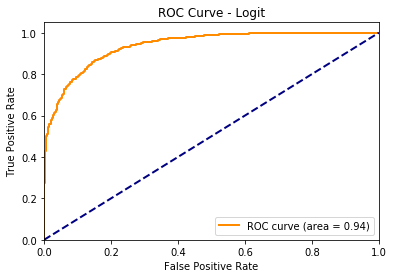

0.9380227362275235

In [34]:
plot_roc(y_hat_logit, modelo='Logit')

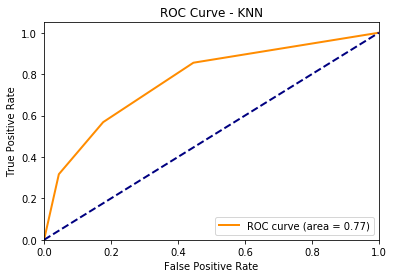

0.7712060767246937

In [35]:
plot_roc(y_hat_knn, modelo='KNN')

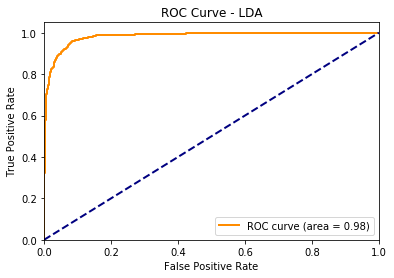

0.9812464180815245

In [36]:
plot_roc(y_hat_lda, modelo='LDA')

Aca vemos como en LDA la curva ROC genera la mayor área debajo la curva. De esta forma se logra  minimizar los falsos positivos y maximizar los verdaderos positivos, respecto de los otros dos modelos estudiados. 


In [ ]:
Ahora hacemos las matrices de confusión para los tres modelos.

Confusion matrix, without normalization
[[1200   69]
 [ 212  492]]
Confusion matrix, without normalization
[[1045  224]
 [ 304  400]]
Confusion matrix, without normalization
[[1178   91]
 [  44  660]]


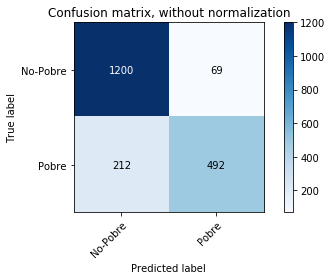

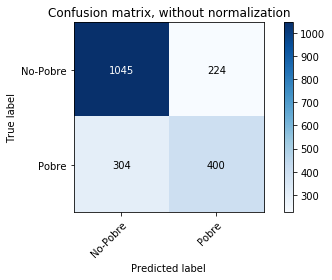

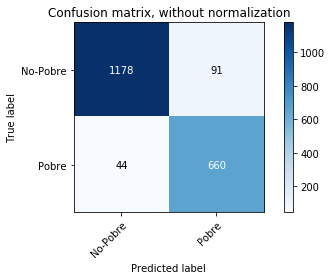

In [37]:
y_pred_logit =  (y_hat_logit[:,1] > 0.5).astype("int")
y_pred_knn =  (y_hat_knn[:,1] > 0.5).astype("int")
y_pred_lda =  (y_hat_lda[:,1] > 0.5).astype("int")

cm_logit, ax = plot_confusion_matrix(y_test, y_pred_logit, classes=[0, 1],
                                 normalize=False,
                                 title=None,
                                 cmap=plt.cm.Blues)

cm_knn, ax = plot_confusion_matrix(y_test, y_pred_knn, classes=[0, 1],
                                 normalize=False,
                                 title=None,
                                 cmap=plt.cm.Blues)

cm_lda, ax = plot_confusion_matrix(y_test, y_pred_lda, classes=[0, 1],
                                 normalize=False,
                                 title=None,
                                 cmap=plt.cm.Blues)

In [43]:
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()

accuracy_logit = accuracy(cm_logit)
accuracy_knn = accuracy(cm_knn)
accuracy_lda = accuracy(cm_lda)

accuracy_logit, accuracy_knn, accuracy_lda

(0.8575772934617334, 0.7323872275722251, 0.9315762797769893)

La mejor Accuracy la tiene LDA, con 93%. Performando de nuevo mejor que los otros dos modelos.  

In [ ]:
Ahora vamos a usar LDA para calcular la cantidad de pobres que hay entre los que no respondieron sus ingresos. 

In [39]:
X_new = norespuesta[X_train.columns]

In [40]:
ypred_new = lda.predict(imp.transform(X_new))
ypred_new

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
pd.DataFrame(ypred_new)[0].value_counts()

0    1858
1     241
Name: 0, dtype: int64

In [44]:
1858/(1858+241)


0.8851834206765127

La proporción de pobres que no respondieron sus ingresos es de 88%. De esta manera queda en evidencia entre la población que no declara sus ingresos en la Encuesta Permanente a Hogares, la gran mayoría es pobre. 